<a href="https://colab.research.google.com/github/MadanMaram/CIFAR-10-Pytorch/blob/master/cifar10_pytorch_ResNet_152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Cifar-10 Classifier using ResNet-152

- ResNet won first place in the ILSVRC-2015 top 5 error rate of 3.57

- this is one my all time favorite architecture

# import libraries

In [12]:
import torch
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()
   
if train_on_gpu:
    print("CUDA is available! Training on GPU...")
else:
    print("CUDA is not available. Training on CPU...")

CUDA is available! Training on GPU...


# Load the data
Download the data.

Load training and test data.

Preprocessing and data augmentation

Split training data into training and validation.

Create DataLoaders for each of these sets of data.

In [14]:
# Number of subprocesses to use for data loading
num_workers = 0

# How many samples per batch to load
batch_size = 20

# Percentage of training set to use as validation
n_valid = 0.2

# Convert data to a normalized torch.FloatTensor
# Data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
                                transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Select training_set and testing_set
train_data = datasets.CIFAR10("data", 
                              train= True,
                             download=True,
                             transform = transform)

test_data = datasets.CIFAR10("data", 
                              train= False,
                             download=True,
                             transform = transform)

# Get indices for training_set and validation_set
n_train = len(train_data)
indices = list(range(n_train))
np.random.shuffle(indices)
split = int(np.floor(n_valid * n_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size = batch_size,
                                          sampler = train_sampler,
                                          num_workers = num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size = batch_size,
                                          sampler = valid_sampler,
                                          num_workers = num_workers)

test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size = batch_size,
                                          num_workers = num_workers)

# Specify the image classes
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]


Files already downloaded and verified
Files already downloaded and verified


# visualize batch of a training data

In [15]:
# Helper function to display the image
def imshow(img):
    # Un-normalize and display the image
    img = img / 2 + 0.5
    # Convert from tensor image
    plt.imshow(np.transpose(img, (1,2,0)))

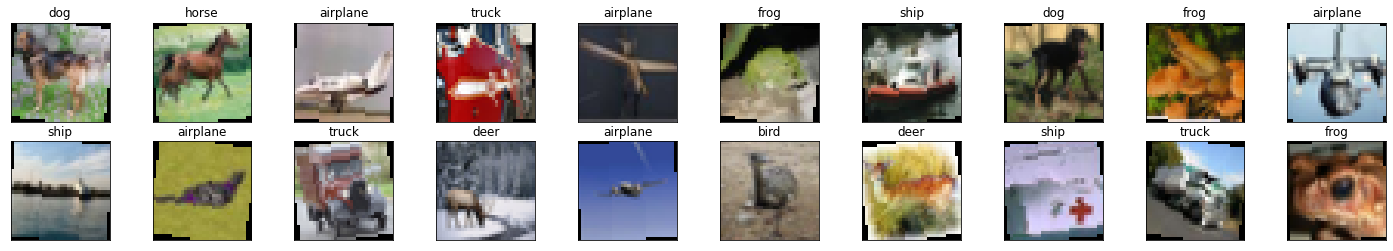

In [16]:
# Get one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# view image as more details

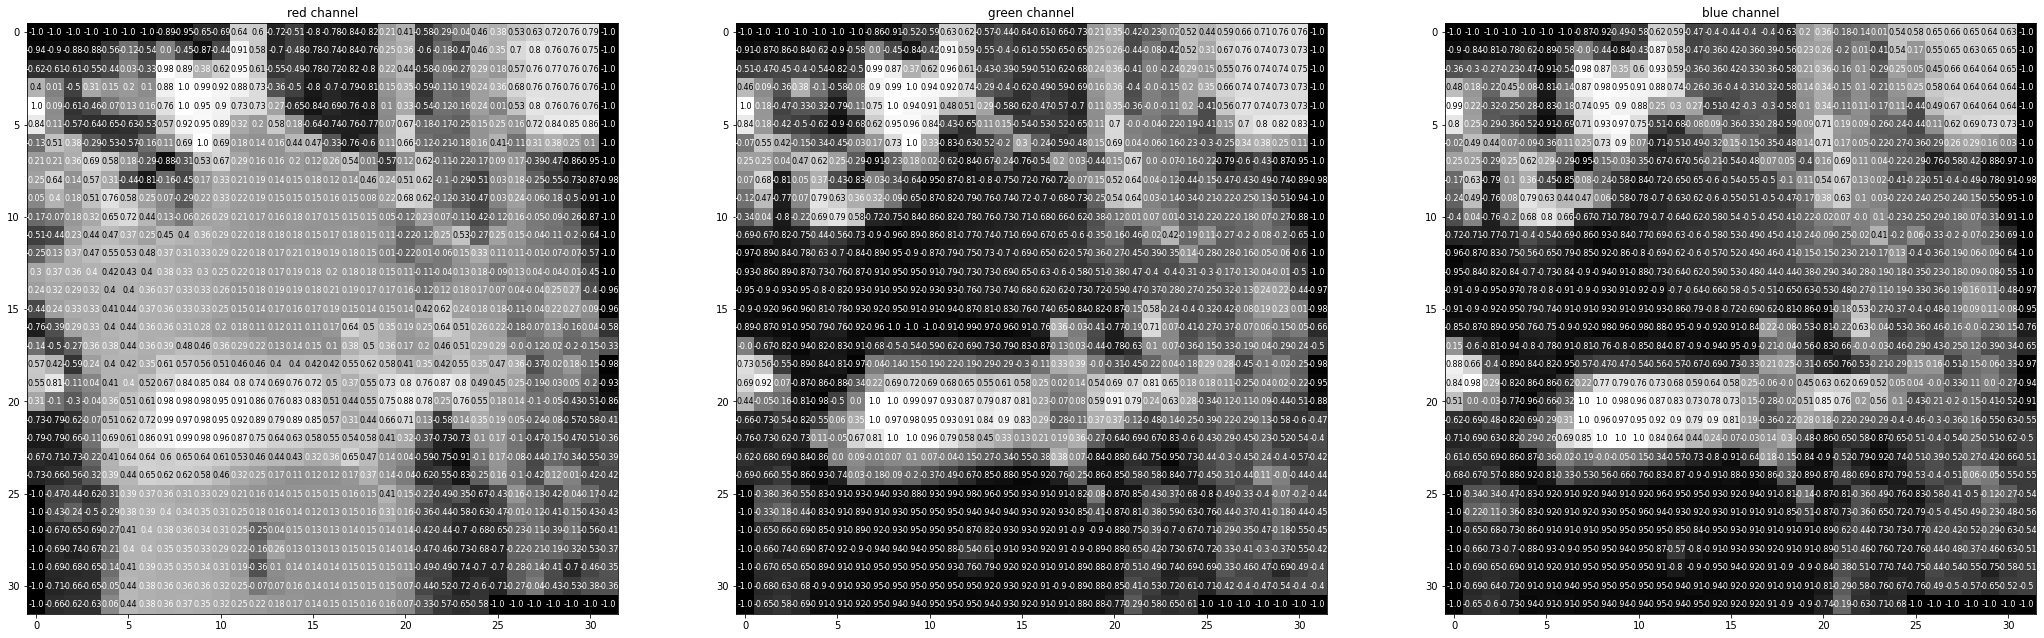

In [17]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

# Define ResNet-152 architecture

In [18]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet152()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

model = ResNet152()
print(model)

# Move tensors to GPU is CUDA is available
if train_on_gpu:
    model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

# specify the loss function and optimizer

In [19]:
# Specify the Loss function
criterion = nn.CrossEntropyLoss()

# Specify the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# traning the network

In [20]:
# number of epochs to train the model
n_epochs = 25 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.495504 	Validation Loss: 0.314880
Validation loss decreased (inf --> 0.314880).  Saving model ...
Epoch: 2 	Training Loss: 1.183073 	Validation Loss: 0.268011
Validation loss decreased (0.314880 --> 0.268011).  Saving model ...
Epoch: 3 	Training Loss: 1.009523 	Validation Loss: 0.213296
Validation loss decreased (0.268011 --> 0.213296).  Saving model ...
Epoch: 4 	Training Loss: 0.874590 	Validation Loss: 0.204269
Validation loss decreased (0.213296 --> 0.204269).  Saving model ...
Epoch: 5 	Training Loss: 0.770143 	Validation Loss: 0.180928
Validation loss decreased (0.204269 --> 0.180928).  Saving model ...
Epoch: 6 	Training Loss: 0.686608 	Validation Loss: 0.157933
Validation loss decreased (0.180928 --> 0.157933).  Saving model ...
Epoch: 7 	Training Loss: 0.607362 	Validation Loss: 0.147389
Validation loss decreased (0.157933 --> 0.147389).  Saving model ...
Epoch: 8 	Training Loss: 0.546467 	Validation Loss: 0.135396
Validation loss decreased (0.14738

In [21]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [22]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.590380

Test Accuracy of airplane: 87% (870/1000)
Test Accuracy of automobile: 91% (914/1000)
Test Accuracy of  bird: 75% (759/1000)
Test Accuracy of   cat: 56% (563/1000)
Test Accuracy of  deer: 81% (811/1000)
Test Accuracy of   dog: 78% (789/1000)
Test Accuracy of  frog: 89% (891/1000)
Test Accuracy of horse: 88% (889/1000)
Test Accuracy of  ship: 88% (889/1000)
Test Accuracy of truck: 90% (909/1000)

Test Accuracy (Overall): 82% (8284/10000)
